<a href="https://colab.research.google.com/github/fjgr/IA_BigData/blob/main/7RO/TAREA%206%20CNN%20(Chess%20Data%20Set)/7RO_Tarea_6_CNN_(Chess_Data_Set).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importación de librerías**
---
En esta celda, se importan todas las librerías necesarias para el procesamiento de imágenes, la manipulación de datos y la creación del modelo en TensorFlow.

In [1]:
pip install squarify split-folders

In [2]:
# Importación de librerías estándar
import os  # Manejo de archivos y directorios
import numpy as np  # Cálculos numéricos y matrices
import pandas as pd  # Manipulación de datos estructurados
import random  # Generación de valores aleatorios

# Visualización de datos
import matplotlib.pyplot as plt  # Gráficos generales
import seaborn as sns  # Gráficos avanzados (heatmaps, distribución de datos)
import squarify  # Gráficos de distribución de clases en formato "treemap"

# Manejo y preprocesamiento del dataset
import splitfolders  # Divide automáticamente el dataset en train/val/test
import requests  # Para descargar archivos desde la web
import zipfile  # Para extraer archivos ZIP
import cv2  # Procesamiento de imágenes con OpenCV
import glob  # Búsqueda de archivos dentro de directorios

# Evaluación del modelo
from sklearn.metrics import classification_report  # Métricas de clasificación (precision, recall, F1-score)

# TensorFlow y Keras (Deep Learning)
import tensorflow as tf  # Framework principal para IA

# Regularización e inicialización de pesos para evitar sobreajuste y mejorar convergencia
from tensorflow.keras.regularizers import l2  # Regularización L2
from tensorflow.keras.initializers import HeNormal  # Inicialización de pesos optimizada para ReLU

# Construcción del modelo de Deep Learning
from tensorflow.keras import Sequential, layers  # Creación de modelos secuenciales y capas
from tensorflow.keras.layers import (
    Dense, Activation, Dropout, Conv2D, GlobalMaxPooling2D, Rescaling,  # Capas principales
    RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth  # Data Augmentation
)

# Carga de imágenes en formato dataset de TensorFlow
from tensorflow.keras.utils import image_dataset_from_directory


## Configuración del estilo de gráficos
Se establece el estilo de gráficos en **"ggplot"**, que es un tema visual inspirado en la librería `ggplot2` de R.

### Características del estilo `ggplot`:
✔️ Fondos grises claros.  
✔️ Líneas de cuadrícula más visibles.  
✔️ Mejor contraste para interpretar los datos.  

Esto hará que todas las visualizaciones generadas con `matplotlib` sigan este formato automáticamente.


In [3]:
# Configuración del estilo de gráficos
plt.style.use('ggplot')  # Aplica el estilo "ggplot" para mejorar la visualización de gráficos

## **Descarga y preparación del Dataset**
---

En esta celda, se descarga y prepara el dataset de imágenes de piezas de ajedrez desde un repositorio de **GitHub**.  

### Pasos realizados:
1️⃣ **Descarga del archivo ZIP** desde la URL de GitHub.  
2️⃣ **Verificación del estado de la descarga** (si fue exitosa o falló).  
3️⃣ **Extracción del archivo ZIP** en una carpeta llamada `"chessman_dataset"`.  
4️⃣ **Definición del directorio base del dataset**.  
5️⃣ **División del dataset en entrenamiento, validación y prueba** usando `splitfolders`:  
   - **70%** para entrenamiento.  
   - **20%** para validación.  
   - **10%** para prueba.  
6️⃣ **Confirmación de que la división del dataset fue exitosa**.  

Esto garantiza que los datos estén correctamente organizados antes de ser usados en el modelo.


In [4]:
# URL del dataset alojado en GitHub (formato raw)
url = "https://github.com/fjgr/IA_BigData/raw/refs/heads/main/dataset/Chessman-image-dataset.zip"

# Descargar el archivo ZIP desde la URL
response = requests.get(url)

# Verificar si la descarga fue exitosa
if response.status_code == 200:
    with open("Chessman-image-dataset.zip", "wb") as file:
        file.write(response.content)  # Guardar el archivo ZIP en disco
    print("Archivo descargado exitosamente.")
else:
    print("Error al descargar el archivo:", response.status_code)

# Extraer el contenido del archivo ZIP en una carpeta
with zipfile.ZipFile("Chessman-image-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("chessman_dataset")  # Extraer en la carpeta "chessman_dataset"
print("Archivo extraído en 'chessman_dataset'.")

# Definir la ruta donde se extrajo el dataset
base_dir = "chessman_dataset/Chessman-image-dataset/Chess"

# Dividir el dataset en train (70%), validation (20%) y test (10%)
splitfolders.ratio(
    base_dir,                               # Carpeta de entrada con las imágenes
    output="Data/Preprocessed Dataset",     # Carpeta de salida para los conjuntos
    seed=42,                                # Fijar semilla para reproducibilidad
    ratio=(0.7, 0.2, 0.1),                  # Porcentaje de división de los datos
    group_prefix=None,
    move=False  # Copia los archivos en lugar de moverlos
)
print("Dataset dividido en train, validation y test.")  # Mensaje de confirmación

Archivo descargado exitosamente.
Archivo extraído en 'chessman_dataset'.


Copying files: 556 files [00:00, 3282.23 files/s]

Dataset dividido en train, validation y test.


## **Análisis de datos**
---

## Distribución de clases en el Dataset

En esta celda, se analiza la distribución de imágenes por clase en el conjunto de datos crudo (`raw dataset`).

### Pasos realizados:
1️⃣ **Definir el directorio base** donde se almacenan las imágenes sin procesar.  
2️⃣ **Crear una lista con los nombres de las clases en inglés y su equivalente en español**.  
3️⃣ **Contar cuántas imágenes hay en cada categoría** utilizando `os.listdir()`.  
4️⃣ **Visualizar la distribución de clases** con un gráfico `squarify` (treemap).  
5️⃣ **Personalizar la gráfica** con colores, etiquetas y títulos.

### Objetivo:
Este análisis ayuda a identificar posibles desbalances en la cantidad de imágenes por clase antes de entrenar el modelo.


(0.0, 100.0, 0.0, 100.0)

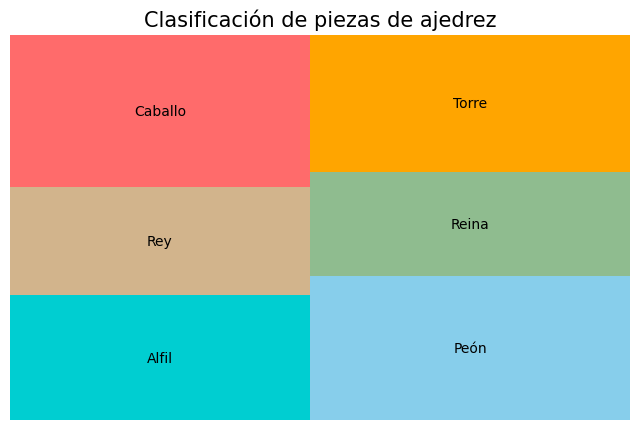

In [5]:
# Directorio donde se encuentra el dataset crudo (sin preprocesar)
raw_images_dir = "chessman_dataset/Chessman-image-dataset/Chess"

# Nombres de las clases en inglés (coinciden con los nombres de las carpetas)
class_names = ["Bishop", "King", "Knight", "Pawn", "Queen", "Rook"]

# Nombres de las clases en español (para visualización)
clases = ['Alfil', 'Rey', 'Caballo', 'Peón', 'Reina', 'Torre']

# Contar cuántas imágenes hay en cada clase
image_counts = [len(os.listdir(os.path.join(raw_images_dir, class_name))) for class_name in class_names]

# Crear una figura para el gráfico de distribución de clases
fig, ax = plt.subplots(figsize=(8, 5))

# Definir colores personalizados para cada clase
colors = ["#00CED1", "#D2B48C", "#FF6B6B", "#87CEEB", "#8FBC8F", "#FFA500"]

# Crear gráfico de distribución de clases (treemap)
squarify.plot(image_counts, label=clases, ax=ax, text_kwargs={"fontsize": 10}, color=colors)

# Personalizar la visualización
plt.title("Clasificación de piezas de ajedrez", fontsize=15)  # Agregar título
plt.axis("off")  # Ocultar ejes


## Distribución de clases en el Dataset preprocesado

En esta celda, se analiza la cantidad de imágenes disponibles en cada clase dentro de los conjuntos de **entrenamiento, validación y prueba**.

### Pasos realizados:
1️⃣ **Definir el directorio base** del dataset preprocesado.  
2️⃣ **Inicializar listas vacías** para almacenar la cantidad de imágenes por clase en cada subconjunto.  
3️⃣ **Recorrer cada clase y contar imágenes** en `train`, `val` y `test`.  
   - Se verifican las rutas antes de acceder a los archivos para evitar errores.  
   - Se imprime una advertencia si alguna carpeta está ausente.  
4️⃣ **Convertir las listas en arreglos NumPy** para facilitar cálculos posteriores.  
5️⃣ **Crear un gráfico de barras apiladas** con los datos de distribución por clase.  
   - **Negro** → Conjunto de **entrenamiento**  
   - **Rojo oscuro** → Conjunto de **validación**  
   - **Azul claro** → Conjunto de **prueba**  

Este análisis ayuda a comprobar si la distribución de datos es equilibrada entre los conjuntos.


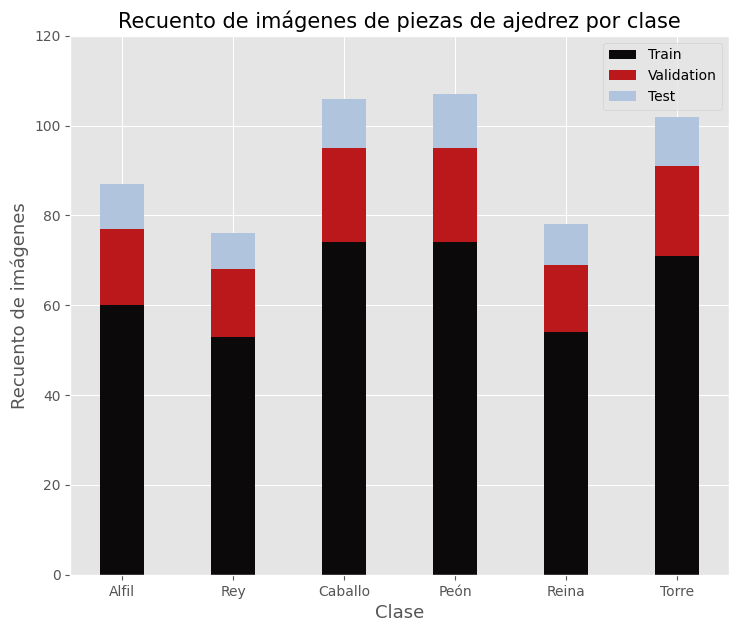

In [6]:
# Directorio donde se almacena el dataset preprocesado
pre_images_dir = "Data/Preprocessed Dataset"

# Inicializar listas vacías para almacenar el conteo de imágenes
train_image_counts = []  # Cantidad de imágenes en el conjunto de entrenamiento
val_image_counts = []    # Cantidad de imágenes en el conjunto de validación
test_image_counts = []   # Cantidad de imágenes en el conjunto de prueba

# Contar imágenes por clase en cada subconjunto
for class_name in class_names:
    train_path = os.path.join(pre_images_dir, "train", class_name)  # Ruta de train
    val_path = os.path.join(pre_images_dir, "val", class_name)      # Ruta de validación
    test_path = os.path.join(pre_images_dir, "test", class_name)    # Ruta de test

    # Verificar si la carpeta de entrenamiento existe antes de contar imágenes
    if os.path.exists(train_path):
        train_image_counts.append(len(os.listdir(train_path)))  # Contar imágenes
    else:
        train_image_counts.append(0)  # Si la carpeta no existe, añadir 0
        print(f"Warning: Directory not found: {train_path}")

    # Verificar si la carpeta de validación existe antes de contar imágenes
    if os.path.exists(val_path):
        val_image_counts.append(len(os.listdir(val_path)))
    else:
        val_image_counts.append(0)
        print(f"Warning: Directory not found: {val_path}")

    # Verificar si la carpeta de prueba existe antes de contar imágenes
    if os.path.exists(test_path):
        test_image_counts.append(len(os.listdir(test_path)))
    else:
        test_image_counts.append(0)
        print(f"Warning: Directory not found: {test_path}")

# Convertir las listas en arreglos NumPy para facilitar cálculos posteriores
train_image_counts = np.array(train_image_counts)
val_image_counts = np.array(val_image_counts)
test_image_counts = np.array(test_image_counts)

# Crear gráfico de barras apiladas para visualizar la cantidad de imágenes por clase
fig, ax = plt.subplots(figsize=(8.5, 7))

# Barras de entrenamiento (negro)
ax.bar(clases, train_image_counts, width=0.4, label="Train", color="#0b090a")

# Barras de validación (rojo oscuro), apiladas sobre las de entrenamiento
ax.bar(clases, val_image_counts, width=0.4, label="Validation", bottom=train_image_counts, color="#ba181b")

# Barras de prueba (azul claro), apiladas sobre las de entrenamiento y validación
ax.bar(clases, test_image_counts, width=0.4, label="Test", bottom=train_image_counts + val_image_counts, color="#b0c4de")

# Personalización del gráfico
ax.set_ylim(0, 120)  # Establecer límite del eje Y
plt.ylabel("Recuento de imágenes", fontsize=13)  # Etiqueta del eje Y
plt.xlabel("Clase", fontsize=13)  # Etiqueta del eje X
plt.title("Recuento de imágenes de piezas de ajedrez por clase", fontsize=15)  # Título del gráfico
ax.legend();  # Mostrar leyenda

## Visualización de imágenes del Dataset crudo

En esta celda, se selecciona una imagen aleatoria de cada clase en el conjunto de datos crudo (`raw dataset`) y se muestran en una cuadrícula de subgráficos.

### Pasos realizados:
1️⃣ **Definir una lista vacía** donde se almacenarán las rutas de las imágenes seleccionadas.  
2️⃣ **Recorrer cada clase del dataset** y elegir una imagen aleatoria.  
3️⃣ **Guardar la ruta de cada imagen seleccionada** en una lista.  
4️⃣ **Crear una figura de 2 filas × 3 columnas** para visualizar las imágenes.  
5️⃣ **Mostrar cada imagen en su respectiva celda del subplot**, junto con su etiqueta correspondiente.  
6️⃣ **Ocultar los ejes** para mejorar la presentación.  

### Objetivo:
Este proceso permite verificar visualmente que las imágenes están correctamente organizadas y disponibles antes de entrenar el modelo.


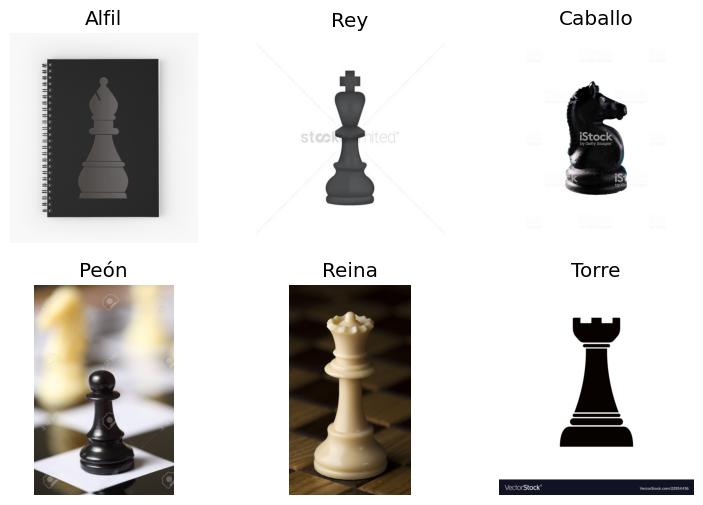

In [7]:
# Lista donde se almacenarán las rutas de las imágenes seleccionadas
images = []

# Seleccionar aleatoriamente una imagen de cada clase
for class_name in class_names:
    image_files = os.listdir(os.path.join(raw_images_dir, class_name))  # Obtener lista de imágenes de la clase
    image_file = random.choice(image_files)  # Seleccionar una imagen al azar
    images.append(os.path.join(raw_images_dir, class_name, image_file))  # Guardar la ruta de la imagen seleccionada

# Crear una figura con 2 filas y 3 columnas para mostrar las imágenes
fig, ax = plt.subplots(2, 3, figsize=(9, 6))

# Recorrer las imágenes y mostrarlas en la cuadrícula de subgráficos
for i in range(6):
    ax[i // 3, i % 3].imshow(plt.imread(images[i]))  # Cargar y mostrar la imagen
    ax[i // 3, i % 3].set(title=clases[i])  # Asignar el título con el nombre de la clase
    ax[i // 3, i % 3].axis('off')  # Ocultar los ejes para una mejor visualización

## **Preprocesamiento de imágenes**
---

## Redimensionamiento

En esta celda, se recorren las imágenes dentro del dataset preprocesado (`train`, `val`, `test`) y se **redimensionan** a un tamaño estándar de **224 × 224 píxeles**.

### Pasos realizados:
1️⃣ **Obtener una lista de los directorios principales (`train`, `val`, `test`)**.  
2️⃣ **Recorrer cada uno de estos directorios** para obtener las carpetas de clases.  
3️⃣ **Para cada clase, obtener la lista de imágenes disponibles**.  
4️⃣ **Cargar cada imagen y redimensionarla** a `(224, 224)` usando OpenCV.  
5️⃣ **Convertir la imagen a `float32`** para asegurar compatibilidad con modelos de deep learning.  
6️⃣ **Sobrescribir la imagen original** con la versión redimensionada.  

### Objetivo:
Este paso es fundamental porque **las redes neuronales convolucionales requieren un tamaño de entrada fijo**, y este formato (`224x224`) es compatible con modelos pre-entrenados como VGG, ResNet y MobileNet.

In [8]:
# Obtener la lista de directorios principales en el dataset preprocesado (train, val, test)
main_directories = os.listdir(pre_images_dir)

# Recorrer cada directorio principal
for main_directory in main_directories:
    main_directory_path = os.path.join(pre_images_dir, main_directory)  # Ruta del conjunto de datos (train, val, test)
    sub_directories = os.listdir(main_directory_path)  # Obtener las clases dentro del conjunto

    # Recorrer cada subdirectorio (cada clase dentro de train, val, test)
    for sub_directory in sub_directories:
        sub_directory_path = os.path.join(main_directory_path, sub_directory)  # Ruta de la clase
        image_paths = glob.glob(os.path.join(sub_directory_path, '*jpg'))  # Obtener todas las imágenes .jpg

        # Recorrer todas las imágenes dentro de la clase y redimensionarlas
        for image_path in image_paths:
            img = cv2.imread(image_path)  # Cargar la imagen
            img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)  # Redimensionar a 224x224
            img = img.astype(np.float32)  # Convertir a tipo float32 para compatibilidad con TensorFlow
            cv2.imwrite(image_path, img)  # Sobrescribir la imagen original con la versión redimensionada


## Carga del Dataset preprocesado en TensorFlow

En esta celda, se cargan los conjuntos de **entrenamiento, validación y prueba** usando `image_dataset_from_directory`, que convierte automáticamente las imágenes en datasets listos para entrenar modelos en **TensorFlow**.

### Pasos realizados:
1️⃣ **Cargar el dataset de entrenamiento (`train_data`)**  
   - Las imágenes se obtienen desde la carpeta `"Data/Preprocessed Dataset/train"`.  
   - Se asignan etiquetas en formato **categorical** (codificación one-hot).  
   - Se redimensionan automáticamente a **224 × 224 píxeles**.  
   - Se usa `seed=42` para asegurar que la aleatorización sea reproducible.  

2️⃣ **Cargar el dataset de validación (`val_data`)**  
   - Misma configuración que `train_data`, pero con imágenes de la carpeta `"val"`.  

3️⃣ **Cargar el dataset de prueba (`test_data`)**  
   - Misma configuración, pero **sin aplicar aleatorización** (`shuffle=False`) para que las predicciones se mantengan en orden.

### Objetivo:
Este proceso facilita el manejo de datos en **TensorFlow**, aplicando preprocesamiento básico antes de alimentar las imágenes a la red neuronal.


In [9]:
# Cargar el conjunto de entrenamiento
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Data/Preprocessed Dataset/train',  # Carpeta de imágenes preprocesadas
    label_mode="categorical",  # Etiquetas en formato one-hot
    image_size=(224, 224),  # Redimensionar imágenes a 224x224 píxeles
    seed=42  # Semilla para garantizar aleatorización reproducible
)

Found 383 files belonging to 6 classes.


In [10]:
# Cargar el conjunto de validación
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Data/Preprocessed Dataset/val',  # Carpeta de imágenes preprocesadas
    label_mode="categorical",  # Etiquetas en formato one-hot
    image_size=(224, 224),  # Redimensionar imágenes a 224x224 píxeles
    seed=42  # Semilla para reproducibilidad
)

Found 108 files belonging to 6 classes.


In [11]:
# Cargar el conjunto de prueba (test)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Data/Preprocessed Dataset/test',  # Carpeta de imágenes preprocesadas
    label_mode="categorical",  # Etiquetas en formato one-hot
    image_size=(224, 224),  # Redimensionar imágenes a 224x224 píxeles
    seed=42,  # Semilla para consistencia
    shuffle=False  # No aleatorizar el orden de las imágenes para evaluar correctamente
)

Found 61 files belonging to 6 classes.


## **Modelo**
---

## Capa de aumento de datos (Data Augmentation)

En esta celda, se crea una capa de **Data Augmentation** usando `Sequential()`, que aplicará transformaciones aleatorias a las imágenes de entrada **durante el entrenamiento**.  

### Técnicas aplicadas:
1️⃣ **`RandomFlip('horizontal')`** → Voltea aleatoriamente las imágenes horizontalmente.  
2️⃣ **`RandomRotation(0.2)`** → Rota las imágenes hasta un **20%** del ángulo total.  
3️⃣ **`RandomHeight(0.2)`** → Modifica la altura en un **20%** de la imagen original.  
4️⃣ **`RandomWidth(0.2)`** → Modifica el ancho en un **20%** de la imagen original.  
5️⃣ **`RandomZoom(0.2)`** → Aplica un zoom aleatorio de hasta **20%**.  

### Objetivo:
El **Data Augmentation** aumenta la diversidad del dataset sin necesidad de recopilar más imágenes, ayudando a reducir el **sobreajuste** y mejorando la **generalización del modelo**.

In [12]:
# Definir la capa de Data Augmentation
data_augmentation = Sequential([
    RandomFlip('horizontal', seed=42),  # Voltea las imágenes horizontalmente de manera aleatoria
    RandomRotation(0.2, seed=42),       # Aplica una rotación aleatoria de hasta el 20%
    RandomHeight(0.2, seed=42),         # Modifica la altura hasta en un 20%
    RandomWidth(0.2, seed=42),          # Modifica el ancho hasta en un 20%
    RandomZoom(0.2, seed=42)            # Aplica un zoom aleatorio de hasta el 20%
])

## Callbacks para el entrenamiento del modelo

En esta celda, se configuran diferentes **callbacks** en TensorFlow para **optimizar y monitorear el entrenamiento** del modelo.

### Callbacks utilizados:
1️⃣ **`ModelCheckpoint`** → Guarda automáticamente el mejor modelo basado en la precisión de validación (`val_accuracy`).  
   - Solo guarda el modelo cuando mejora (`save_best_only=True`).  
   - Se almacena en `'Data/Checkpoint.keras'` para futura carga.  

2️⃣ **`ReduceLROnPlateau`** → Reduce la tasa de aprendizaje (`learning rate`) si la precisión de validación no mejora.  
   - Se activa cuando `val_accuracy` deja de aumentar.  
   - Reduce la tasa de aprendizaje en un **20%** (`factor=0.2`).  
   - Espera **3 epochs sin mejora** antes de reducirla (`patience=3`).  
   - El **mínimo learning rate** permitido es `1e-7`.  

3️⃣ **`CSVLogger`** → Guarda el historial de entrenamiento en un archivo CSV.  
   - **`Base Model History.csv`** → Historial del modelo base.  
   - **`Fine-Tuned Model History.csv`** → Historial después del fine-tuning.  

### Objetivo:
Estos callbacks **mejoran la estabilidad del entrenamiento**, permiten **ajustar automáticamente el learning rate** y facilitan **el monitoreo del progreso del modelo**.


In [13]:
# Callback para guardar el mejor modelo basado en la precisión de validación
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'Data/Checkpoint.keras',  # Ruta donde se guardará el modelo
    save_best_only=True,  # Solo guarda el modelo cuando mejora
    monitor="val_accuracy"  # Se evalúa la mejora en la precisión de validación
)

# Callback para reducir la tasa de aprendizaje si la precisión no mejora
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",  # Se monitorea la precisión de validación
    factor=0.2,  # Reduce el learning rate en un 20% si no hay mejoras
    patience=3,  # Espera 3 epochs antes de reducir la tasa de aprendizaje
    min_lr=1e-7  # Establece un límite mínimo para la tasa de aprendizaje
)

# Callbacks para registrar el historial de entrenamiento en archivos CSV
base_csv_logger = tf.keras.callbacks.CSVLogger('Data/Base Model History.csv')  # Historial del modelo base
ft_csv_logger = tf.keras.callbacks.CSVLogger('Data/Fine-Tuned Model History.csv')  # Historial después del fine-tuning

## Construcción del Modelo CNN con VGG19 como Base

En esta celda, se define el modelo de clasificación de imágenes basado en la arquitectura **VGG19** pre-entrenada.

### Estructura del Modelo:
1️⃣ **Modelo Base: VGG19 (sin la última capa fully connected)**  
   - Se carga con `include_top=False` para eliminar la capa final.  
   - Sus pesos están **congelados** (`trainable=False`) para evitar que se actualicen en la primera fase de entrenamiento.  

2️⃣ **Capa de Entrada (`inputs`)**  
   - Tamaño de entrada: **224 × 224 × 3** (RGB).  

3️⃣ **Data Augmentation y Normalización**  
   - Se aplican transformaciones aleatorias (`data_augmentation`).  
   - Se normalizan los píxeles dividiéndolos por 255 (`Rescaling(1./255)`).  

4️⃣ **Capas Convolucionales Adicionales**  
   - **Dos capas `Conv2D(256, 3, relu)`** con regularización **L2 (0.01)** para reducir el sobreajuste.  
   - Se usa inicialización de pesos `HeNormal()` para mejorar la estabilidad del entrenamiento.  

5️⃣ **Regularización con Dropout**  
   - **40% después del modelo base** para evitar sobreajuste.  
   - **40% antes de la capa de salida** para mejorar la generalización.  

6️⃣ **Capa Global de Pooling**  
   - `GlobalMaxPooling2D()` para reducir la dimensionalidad sin perder información clave.  

7️⃣ **Capa de Salida (`Dense(6)`)**  
   - Se usa `softmax` para generar probabilidades de clasificación en **6 clases**.  

8️⃣ **Compilación del Modelo**  
   - Función de pérdida: `categorical_crossentropy` (porque es un problema multiclase).  
   - Optimizador: **Adam**, que ajusta dinámicamente la tasa de aprendizaje.  
   - Métrica de evaluación: **accuracy**.  

### Objetivo:
Este modelo utiliza **Transfer Learning** con **VGG19** para aprovechar conocimientos previos en reconocimiento de imágenes, mientras que las nuevas capas convolucionales permiten ajustar mejor la clasificación de piezas de ajedrez.


In [14]:
# Cargar el modelo base preentrenado VGG19 (sin la capa fully connected)
base_model = tf.keras.applications.VGG19(include_top=False)  # No incluye capa final
base_model.trainable = False  # Congelar los pesos para evitar modificaciones en esta fase

# Definir la capa de entrada del modelo
inputs = tf.keras.Input(shape=(224, 224, 3))  # Entrada de imágenes RGB de 224x224

# Aplicar Data Augmentation y Normalización
x = data_augmentation(inputs)  # Aumento de datos aleatorio
x = layers.Rescaling(1./255)(x)  # Normalización de píxeles (0-255 → 0-1)

# Pasar la imagen a través del modelo base preentrenado
x = base_model(x)

# Regularización con Dropout para evitar sobreajuste
x = layers.Dropout(0.4)(x)  # Desactiva el 40% de las neuronas después de VGG19

# Capas convolucionales adicionales con regularización L2 y inicialización HeNormal
x = layers.Conv2D(256, 3, activation='relu', padding='same',
                   kernel_regularizer=l2(0.01), kernel_initializer=HeNormal())(x)
x = layers.Conv2D(256, 3, activation='relu', padding='same',
                   kernel_regularizer=l2(0.01), kernel_initializer=HeNormal())(x)

# Regularización con Dropout después de las capas convolucionales
x = layers.Dropout(0.4)(x)

# Aplicar Global Max Pooling para reducir la dimensionalidad
x = tf.keras.layers.GlobalMaxPooling2D()(x)

# Última capa de Dropout antes de la capa final
x = layers.Dropout(0.4)(x)

# Capa de salida con 6 neuronas (una por cada clase)
x = layers.Dense(6)(x)
outputs = layers.Activation("softmax")(x)  # Softmax para obtener probabilidades de clasificación

# Construir el modelo final
model = tf.keras.Model(inputs, outputs)

# Compilar el modelo con la función de pérdida y el optimizador Adam
model.compile(loss="categorical_crossentropy",  # Pérdida para clasificación multiclase
              optimizer=tf.keras.optimizers.Adam(),  # Optimizador Adam
              metrics=["accuracy"])  # Métrica de evaluación: Precisión (accuracy)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Carga del dataset y entrenamiento del modelo base

En esta celda, se carga el dataset de entrenamiento y se inicia el entrenamiento del **modelo base**.

### Pasos realizados:
1️⃣ **Cargar el dataset de entrenamiento (`train_data`)**  
   - Se obtienen imágenes desde `"Data/Preprocessed Dataset/train"`.  
   - Se asignan etiquetas en formato **categorical** (codificación one-hot).  
   - Se redimensionan automáticamente a **224 × 224 píxeles**.  
   - Se usa `seed=42` para garantizar reproducibilidad.  

2️⃣ **Obtener los nombres de las clases automáticamente**  
   - Se extraen directamente desde `train_data.class_names`.  

3️⃣ **Entrenar el modelo base (`model.fit`)**  
   - **`epochs=25`** → Entrena el modelo durante **25 iteraciones completas** sobre los datos.  
   - **`steps_per_epoch=len(train_data)`** → Se define cuántos lotes se procesan por epoch.  
   - **`validation_data=val_data`** → Se usa el conjunto de validación para evaluar el rendimiento en cada epoch.  
   - **`callbacks=[model_checkpoint, reduce_lr, base_csv_logger]`** → Se aplican callbacks para:  
     - **Guardar el mejor modelo** (`ModelCheckpoint`).  
     - **Reducir automáticamente el learning rate** si el modelo deja de mejorar (`ReduceLROnPlateau`).  
     - **Registrar el historial de entrenamiento** (`CSVLogger`).  

### Objetivo:
Este proceso entrena la **primera fase del modelo**, con el **modelo base congelado**. Posteriormente, se puede aplicar **fine-tuning** descongelando capas específicas para mejorar el rendimiento.


In [15]:
# Cargar el dataset de entrenamiento desde el directorio preprocesado
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Data/Preprocessed Dataset/train',  # Carpeta con imágenes preprocesadas
    label_mode="categorical",  # Etiquetas en formato one-hot
    image_size=(224, 224),  # Redimensionar imágenes a 224x224 píxeles
    seed=42  # Fijar semilla para reproducibilidad
)

# Obtener automáticamente los nombres de las clases desde el dataset cargado
class_names = train_data.class_names

# Entrenar el modelo base
model.fit(
    train_data,  # Dataset de entrenamiento
    epochs=25,  # Número total de epochs
    steps_per_epoch=len(train_data),  # Definir el número de pasos por epoch
    validation_data=val_data,  # Dataset de validación
    validation_steps=len(val_data),  # Definir pasos por epoch en validación
    callbacks=[model_checkpoint, reduce_lr, base_csv_logger]  # Callbacks para optimización y registro
)

Found 383 files belonging to 6 classes.
Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.1582 - loss: 17.8762 - val_accuracy: 0.2593 - val_loss: 11.1713 - learning_rate: 0.0010
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.1465 - loss: 10.9994 - val_accuracy: 0.2130 - val_loss: 10.1684 - learning_rate: 0.0010
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.1565 - loss: 9.9257 - val_accuracy: 0.1852 - val_loss: 9.1672 - learning_rate: 0.0010
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.2381 - loss: 8.9430 - val_accuracy: 0.1944 - val_loss: 8.2547 - learning_rate: 0.0010
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 999ms/step - accuracy: 0.2315 - loss: 8.2142 - val_accuracy: 0.3704 - val_loss: 8.0686 - learning_rate: 2.0000e-04
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.3138 - loss: 7.9604 - val_accuracy: 0.3611 - val_loss: 7.8563 - learning_rate: 2.0000e-04
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 676m

## Visualización del historial de entrenamiento del modelo base

En esta celda, se carga y visualiza el historial de entrenamiento del **modelo base** almacenado en un archivo CSV.

### Pasos realizados:
1️⃣ **Cargar el historial del entrenamiento desde el archivo CSV**  
   - Se obtiene desde `'Data/Base Model History.csv'`.  
   - Contiene métricas como `loss`, `val_loss`, `accuracy` y `val_accuracy`.  

2️⃣ **Extraer los valores de cada métrica**  
   - `loss`: Pérdida en el conjunto de entrenamiento.  
   - `val_loss`: Pérdida en el conjunto de validación.  
   - `accuracy`: Precisión en el conjunto de entrenamiento.  
   - `val_accuracy`: Precisión en el conjunto de validación.  

3️⃣ **Definir el número de epochs**  
   - Se usa `range(len(loss))` para definir el eje X de las gráficas.  

4️⃣ **Graficar la evolución del entrenamiento**  
   - Se usan **dos subgráficos** (`plt.subplots(2, 1)`).  
   - El primer gráfico muestra la evolución de `loss` y `val_loss`.  
   - El segundo gráfico muestra `accuracy` y `val_accuracy`.  
   - Se agregan etiquetas, límites en el eje Y y una leyenda para mayor claridad.  

### Objetivo:
Visualizar el rendimiento del modelo base a lo largo de las **25 epochs**, identificando si hubo **sobreajuste** o si el modelo aprendió correctamente.


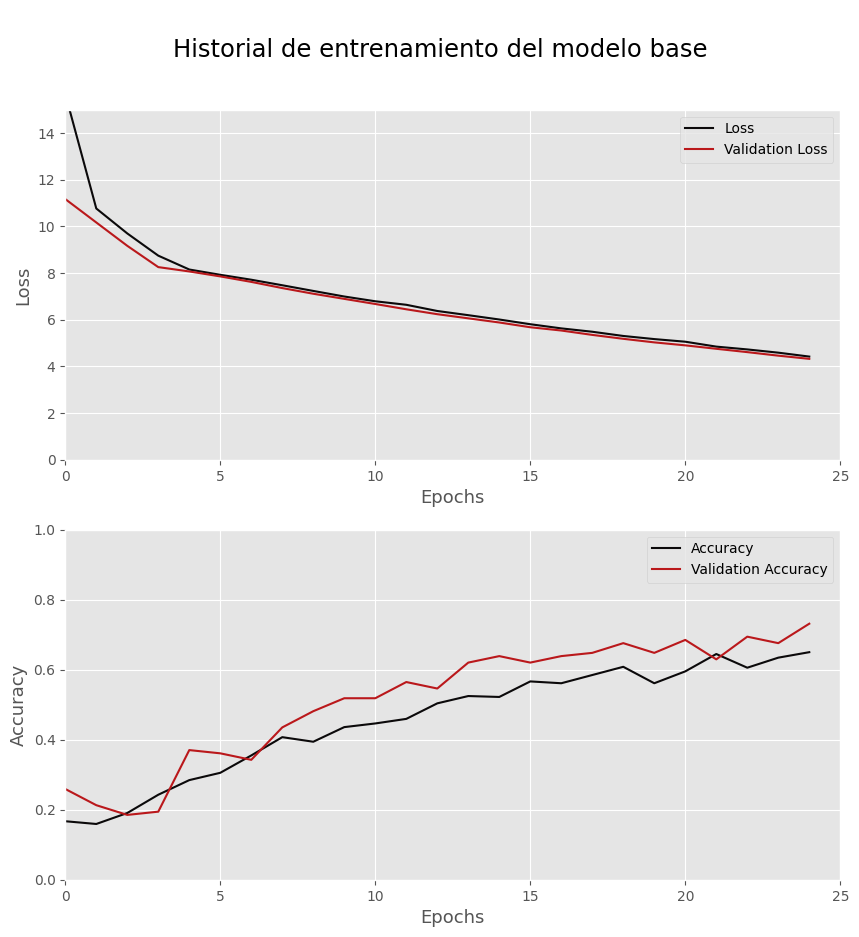

In [20]:
# Cargar el historial de entrenamiento desde el archivo CSV
history = pd.read_csv('Data/Base Model History.csv')

# Extraer valores de las métricas de entrenamiento y validación
loss = history['loss']  # Pérdida en entrenamiento
val_loss = history['val_loss']  # Pérdida en validación
accuracy = history['accuracy']  # Precisión en entrenamiento
val_accuracy = history['val_accuracy']  # Precisión en validación

# Definir el número de epochs para el eje X
epochs = range(len(loss))  # Se usa el total de epochs registradas en el historial

# Crear una figura con dos subgráficos para visualizar las métricas
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Agregar título general
fig.suptitle("\nHistorial de entrenamiento del modelo base", fontsize=17.5)

# Gráfico 1: Evolución de la pérdida (loss)
ax[0].plot(epochs, loss, label='Loss', color="#0B090A")  # Pérdida en entrenamiento
ax[0].plot(epochs, val_loss, label='Validation Loss', color="#BA181B")  # Pérdida en validación
ax[0].set_xlim(0, 25)  # Definir límites en el eje X
ax[0].set_ylim(0, 15)  # Definir límites en el eje Y
ax[0].set_ylabel('Loss', fontsize=13)  # Etiqueta del eje Y
ax[0].set_xlabel('Epochs', fontsize=13)  # Etiqueta del eje X
ax[0].legend()  # Mostrar leyenda

# Gráfico 2: Evolución de la precisión (accuracy)
ax[1].plot(epochs, accuracy, label='Accuracy', color="#0B090A")  # Precisión en entrenamiento
ax[1].plot(epochs, val_accuracy, label='Validation Accuracy', color="#BA181B")  # Precisión en validación
ax[1].set_xlim(0, 25)  # Definir límites en el eje X
ax[1].set_ylim(0, 1)  # Definir límites en el eje Y
ax[1].set_xlabel('Epochs', fontsize=13)  # Etiqueta del eje X
ax[1].set_ylabel('Accuracy', fontsize=13)  # Etiqueta del eje Y
ax[1].legend()  # Mostrar leyenda

## Fine-Tuning del modelo base (VGG19)

En esta celda, se realiza el **ajuste fino (fine-tuning)** del modelo base **VGG19**, permitiendo que **ciertas capas** sean entrenables mientras se mantiene congelada la mayoría del modelo.

### Pasos realizados:
1️⃣ **Descongelar el modelo base (`base_model.trainable = True`)**  
   - Esto permite que todas las capas sean entrenables.  

2️⃣ **Congelar todas las capas excepto las últimas 10**  
   - Se recorre `base_model.layers[:-10]` y se configuran como `trainable = False`.  
   - Solo las **10 capas superiores** se entrenarán.  
   - Esto permite que el modelo ajuste sus pesos para nuestro dataset sin perder el conocimiento preentrenado.  

3️⃣ **Recompilar el modelo (`model.compile`)**  
   - **Función de pérdida:** `categorical_crossentropy` (para clasificación multiclase).  
   - **Optimizador:** `Adam` con un learning rate más bajo (`2e-5`) para evitar sobreajuste.  
   - **Métrica:** `accuracy`, que mide la precisión del modelo.  

### Objetivo:
Este proceso ajusta las últimas capas de **VGG19** para que el modelo aprenda **mejor las características específicas** del dataset de piezas de ajedrez, sin perder el conocimiento previo aprendido en grandes bases de datos de imágenes.

In [21]:
# Descongelar todo el modelo base para permitir su ajuste fino
base_model.trainable = True

# Congelar todas las capas del modelo base, excepto las últimas 10
for layer in base_model.layers[:-10]:
    layer.trainable = False  # Mantener congeladas las capas iniciales

# Volver a compilar el modelo con una tasa de aprendizaje más baja para evitar sobreajuste
model.compile(
    loss="categorical_crossentropy",  # Función de pérdida para clasificación multiclase
    optimizer=tf.keras.optimizers.Adam(learning_rate=2.0000e-05),  # Optimizador Adam con un learning rate bajo
    metrics=["accuracy"]  # Evaluar el modelo en términos de precisión
)

## Entrenamiento del modelo Fine-Tuned

En esta celda, se entrena el modelo con **fine-tuning**, permitiendo que las últimas capas de **VGG19** se ajusten al dataset de piezas de ajedrez.

### Pasos realizados:
1️⃣ **Ejecutar `model.fit()` para entrenar el modelo**  
   - Se entrena durante **25 epochs**.  
   - Se usa el dataset de **entrenamiento** (`train_data`).  
   - Se evalúa en el dataset de **validación** (`val_data`).  

2️⃣ **Definir los parámetros clave**  
   - **`steps_per_epoch=len(train_data)`** → Número de lotes por epoch en entrenamiento.  
   - **`validation_steps=len(val_data)`** → Número de lotes por epoch en validación.  

3️⃣ **Aplicar callbacks para mejorar el entrenamiento**  
   - **`ModelCheckpoint`** → Guarda el mejor modelo basado en la precisión de validación.  
   - **`CSVLogger`** → Guarda el historial del fine-tuning en un archivo CSV.  
   - **`ReduceLROnPlateau`** → Reduce automáticamente la tasa de aprendizaje si el modelo deja de mejorar.  

### Objetivo:
Esta etapa permite ajustar el modelo para mejorar su capacidad de **generalización** sin sobreajuste, afinando los pesos de las capas superiores de **VGG19**.


In [22]:
# Entrenar el modelo fine-tuned con 25 epochs
model.fit(
    train_data,  # Dataset de entrenamiento
    epochs=25,  # Número total de epochs
    steps_per_epoch=len(train_data),  # Definir el número de pasos por epoch en entrenamiento
    validation_data=val_data,  # Dataset de validación
    validation_steps=len(val_data),  # Definir pasos por epoch en validación
    callbacks=[model_checkpoint, ft_csv_logger, reduce_lr]  # Callbacks para optimización y registro
)

Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6104 - loss: 4.3865 - val_accuracy: 0.6944 - val_loss: 4.1901 - learning_rate: 2.0000e-05
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 867ms/step - accuracy: 0.6913 - loss: 4.1624 - val_accuracy: 0.7963 - val_loss: 4.0199 - learning_rate: 2.0000e-05
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 854ms/step - accuracy: 0.7547 - loss: 4.0534 - val_accuracy: 0.7407 - val_loss: 3.8907 - learning_rate: 2.0000e-05
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 964ms/step - accuracy: 0.7691 - loss: 3.7906 - val_accuracy: 0.8148 - val_loss: 3.7475 - learning_rate: 2.0000e-05
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 496ms/step - accuracy: 0.7787 - loss: 3.7236 - val_accuracy: 0.8056 - val_loss: 3.6962 - learning_rate: 2.0000e-05
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 484ms/step - accuracy: 0.7613 - loss: 3.7408 - val_accuracy: 0.7500 - val_loss: 3.6553 - learning_rate: 2.0000e-05
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 633ms/step - accurac

## Visualización del Historial de Entrenamiento del Modelo Fine-Tuned

En esta celda, se carga y visualiza el historial de entrenamiento del modelo **fine-tuned**, permitiendo analizar su desempeño a lo largo de **25 epochs**.

### Pasos realizados:
1️⃣ **Cargar el historial de entrenamiento desde el archivo CSV**  
   - Se obtiene desde `'Data/Fine-Tuned Model History.csv'`.  
   - Contiene métricas como `loss`, `val_loss`, `accuracy` y `val_accuracy`.  

2️⃣ **Extraer los valores de cada métrica**  
   - `loss`: Pérdida en el conjunto de entrenamiento.  
   - `val_loss`: Pérdida en el conjunto de validación.  
   - `accuracy`: Precisión en el conjunto de entrenamiento.  
   - `val_accuracy`: Precisión en el conjunto de validación.  

3️⃣ **Definir el número de epochs**  
   - Se usa `range(len(loss))` para definir el eje X de las gráficas.  

4️⃣ **Graficar la evolución del entrenamiento**  
   - Se generan **dos subgráficos** (`plt.subplots(2, 1)`).  
   - **Gráfico 1:** Evolución de `loss` y `val_loss` (pérdida).  
   - **Gráfico 2:** Evolución de `accuracy` y `val_accuracy` (precisión).  
   - Se agregan etiquetas, límites en los ejes y una leyenda para mayor claridad.  

### Objetivo:
Visualizar el impacto del **fine-tuning** en la precisión del modelo y detectar si hubo **sobreajuste** o mejoras respecto al modelo base.

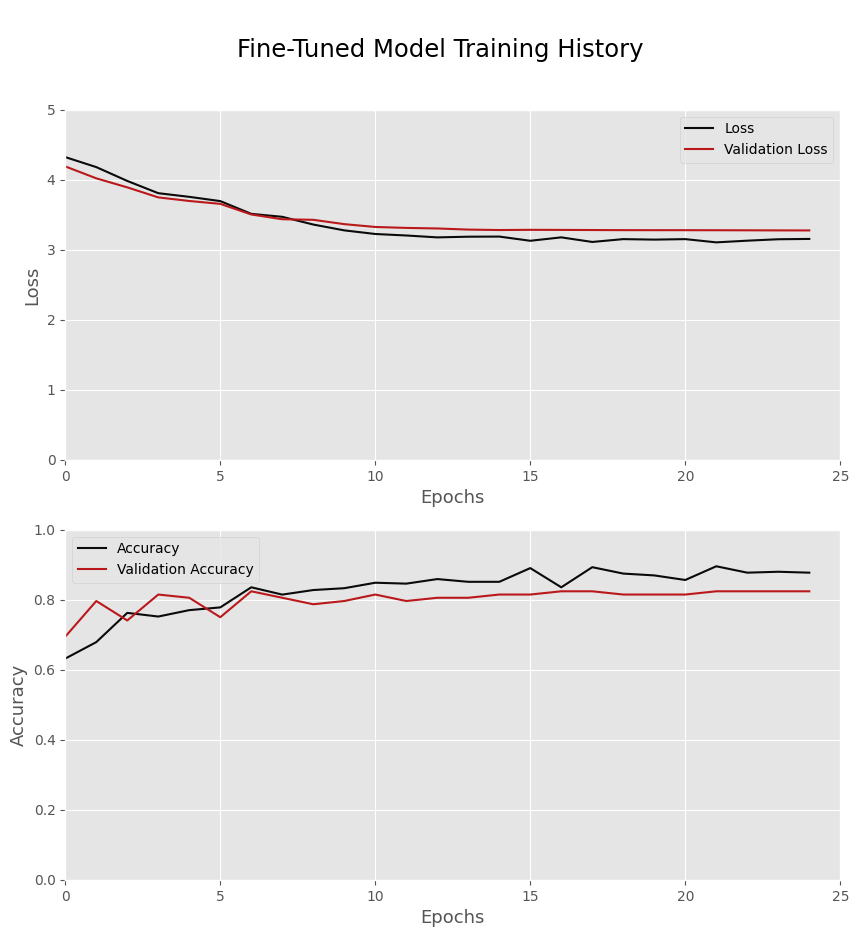

In [24]:
# Cargar el historial de entrenamiento del modelo fine-tuned
history = pd.read_csv('Data/Fine-Tuned Model History.csv')

# Extraer métricas de entrenamiento y validación
loss = history['loss']  # Pérdida en entrenamiento
val_loss = history['val_loss']  # Pérdida en validación
accuracy = history['accuracy']  # Precisión en entrenamiento
val_accuracy = history['val_accuracy']  # Precisión en validación

# Definir el número de epochs para el eje X
epochs = range(len(loss))

# Crear una figura con dos subgráficos
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Agregar título general
fig.suptitle("\nFine-Tuned Model Training History", fontsize=17.5)

# Gráfico 1: Evolución de la pérdida (loss)
ax[0].plot(epochs, loss, label='Loss', color="#0B090A")  # Pérdida en entrenamiento
ax[0].plot(epochs, val_loss, label='Validation Loss', color="#BA181B")  # Pérdida en validación
ax[0].set_xlim(0, 25)  # Limitar eje X al número de epochs
ax[0].set_ylim(0, 5)  # Limitar el eje Y para mayor claridad
ax[0].set_ylabel('Loss', fontsize=13)  # Etiqueta del eje Y
ax[0].set_xlabel('Epochs', fontsize=13)  # Etiqueta del eje X
ax[0].legend()  # Mostrar leyenda

# Gráfico 2: Evolución de la precisión (accuracy)
ax[1].plot(epochs, accuracy, label='Accuracy', color="#0B090A")  # Precisión en entrenamiento
ax[1].plot(epochs, val_accuracy, label='Validation Accuracy', color="#BA181B")  # Precisión en validación
ax[1].set_xlim(0, 25)  # Limitar eje X al número de epochs
ax[1].set_ylim(0, 1)  # Limitar el eje Y para mayor claridad
ax[1].set_xlabel('Epochs', fontsize=13)  # Etiqueta del eje X
ax[1].set_ylabel('Accuracy', fontsize=13)  # Etiqueta del eje Y
ax[1].legend()  # Mostrar leyenda

## **Evaluación**
---

## Carga de pesos del modelo entrenado

En esta celda, se cargan los pesos del mejor modelo guardado durante el entrenamiento.

### Pasos realizados:
1️⃣ **Cargar los pesos guardados desde el archivo `'Data/Checkpoint.keras'`**  
   - Este archivo fue generado por el **callback `ModelCheckpoint`** durante el entrenamiento.  
   - Solo se guardó el **mejor modelo basado en la precisión de validación (`val_accuracy`)**.  

### Objetivo:
Permite restaurar el modelo con los **mejores pesos obtenidos** durante el entrenamiento sin necesidad de volver a entrenarlo.


In [25]:
# Cargar los pesos del mejor modelo guardado durante el entrenamiento
model.load_weights('Data/Checkpoint.keras')  # Carga los pesos previamente guardados

## Evaluación del modelo en el conjunto de prueba (Test Set)

En esta celda, se evalúa el modelo en el **dataset de prueba (`test_data`)** para calcular su precisión final.

### Pasos realizados:
1️⃣ **Evaluar el modelo con `model.evaluate(test_data)`**  
   - Retorna dos valores: `[loss, accuracy]`.  
   - Solo se extrae la **precisión (`accuracy`)**.  

2️⃣ **Multiplicar por 100**  
   - Convierte la precisión a **porcentaje (%)** para una mejor interpretación.  

### Objetivo:
Obtener el rendimiento **real del modelo** en imágenes **nunca vistas**, lo que indica su capacidad de generalización.


In [26]:
# Evaluar el modelo en el conjunto de prueba y extraer la precisión
accuracy = model.evaluate(test_data)[1] * 100  # Multiplicar por 100 para mostrar en porcentaje

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8808 - loss: 3.6104


## Visualización de la precisión del modelo en el conjunto de prueba

En esta celda, se genera un gráfico de **barra horizontal** para representar la **precisión final del modelo en el test set**.

### Pasos realizados:
1️⃣ **Crear una figura y un eje con `plt.subplots()`**.  
2️⃣ **Dibujar dos barras horizontales (`ax.barh`)**:  
   - Una barra de **color negro (`#0B090A`)** representando el **100%** de precisión.  
   - Una barra de **color rojo (`#BA181B`)** representando la **precisión real del modelo (`accuracy`)**.  
3️⃣ **Configurar el gráfico**:  
   - `ax.set_aspect('equal')` → Mantiene la proporción de la gráfica.  
   - `ax.set_xlim(0, 100)` → Limita el eje X de 0 a 100 para indicar porcentaje.  
   - `ax.set_yticks([1])` y `ax.set_yticklabels('%')` → Personaliza las etiquetas del eje Y.  
   - `ax.set(title='Accuracy')` → Agrega un título al gráfico.  

### Objetivo:
Mostrar de forma visual e intuitiva **qué tan preciso es el modelo** en comparación con un 100% ideal.


[Text(0.5, 1.0, 'Accuracy')]

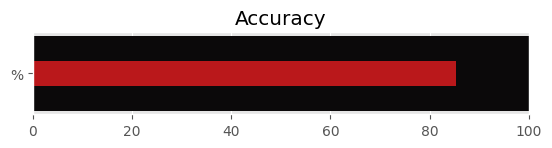

In [27]:
# Crear una figura y un eje para el gráfico de barras horizontales
fig, ax = plt.subplots()

# Dibujar una barra negra representando el 100% de precisión
ax.barh([1], 100, left=0, height=15, color="#0B090A")

# Dibujar una barra roja representando la precisión real del modelo
ax.barh([1], accuracy, color="#BA181B", height=5)

# Configuración del gráfico
ax.set_aspect('equal')  # Mantener la proporción del gráfico
ax.set_yticks([1])  # Posición de la etiqueta en el eje Y
ax.set_yticklabels('%')  # Etiqueta del eje Y indicando porcentaje
ax.set_xlim(0, 100)  # Limitar el eje X entre 0 y 100
ax.set(title='Accuracy')  # Agregar título al gráfico

## Predicciones en el Conjunto de Prueba (Test Set)

En esta celda, se realizan predicciones sobre las imágenes del **test set** y se extraen las etiquetas verdaderas para comparar con las predicciones.

### Pasos realizados:
1️⃣ **Obtener las predicciones del modelo (`model.predict(test_data)`)**  
   - Devuelve una matriz con las probabilidades de cada clase para cada imagen.  

2️⃣ **Convertir las probabilidades en etiquetas predichas**  
   - Se usa `np.argmax(test_pred, axis=1)` para obtener la clase con la **mayor probabilidad**.  

3️⃣ **Obtener las etiquetas verdaderas del dataset de prueba**  
   - Se recorre `test_data.unbatch()` para acceder a cada imagen y su etiqueta correspondiente.  
   - Se usa `.numpy().argmax()` para extraer la clase verdadera en formato entero.  

### Objetivo:
Obtener **las predicciones del modelo y las etiquetas verdaderas**, lo que permitirá calcular métricas de evaluación como **precisión, recall y matriz de confusión**.


In [28]:
# Obtener las predicciones del modelo en el conjunto de prueba
test_pred = model.predict(test_data)  # Devuelve una matriz de probabilidades para cada imagen

# Convertir las probabilidades en etiquetas predichas (índice con mayor probabilidad)
test_pred = np.argmax(test_pred, axis=1)

# Lista vacía para almacenar las etiquetas verdaderas
test_true = []

# Recorrer el dataset de prueba y extraer las etiquetas verdaderas
for images, labels in test_data.unbatch():
    test_true.append(labels.numpy().argmax())  # Convertir las etiquetas one-hot en valores enteros

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 358ms/step


## Evaluación del Modelo: Reporte de Clasificación y Métricas

En esta celda, se calcula el **reporte de clasificación** del modelo en el **conjunto de prueba** y se visualizan las métricas de desempeño de cada clase.

### Pasos realizados:
1️⃣ **Calcular el `classification_report`**  
   - Se compara `test_true` (etiquetas reales) vs. `test_pred` (predicciones del modelo).  
   - Se obtiene **precisión, recall y F1-score** para cada clase.  
   - Se almacena en un diccionario (`output_dict=True`) para facilitar su manipulación.  

2️⃣ **Extraer las métricas clave**  
   - Se definen las métricas a graficar: `["precision", "recall", "f1-score"]`.  
   - Se almacenan en una lista `class_scores` para cada una de las **6 clases**.  

3️⃣ **Generar gráfico de barras comparando las métricas**  
   - Se usa `bar_width=0.2` para evitar solapamiento de barras.  
   - Se generan **tres barras por clase**, una para cada métrica (precisión, recall y F1-score).  
   - Se personalizan colores para cada métrica:  
     - **Negro (`#0b090a`)** → Precisión  
     - **Rojo (`#ba181b`)** → Recall  
     - **Azul (`#b0c4de`)** → F1-score  

### Objetivo:
Visualizar de forma clara y comparativa el desempeño del modelo en cada clase, identificando **posibles desbalances** o clases con bajo rendimiento.


Text(0.5, 1.0, 'Métricas de rendimiento')

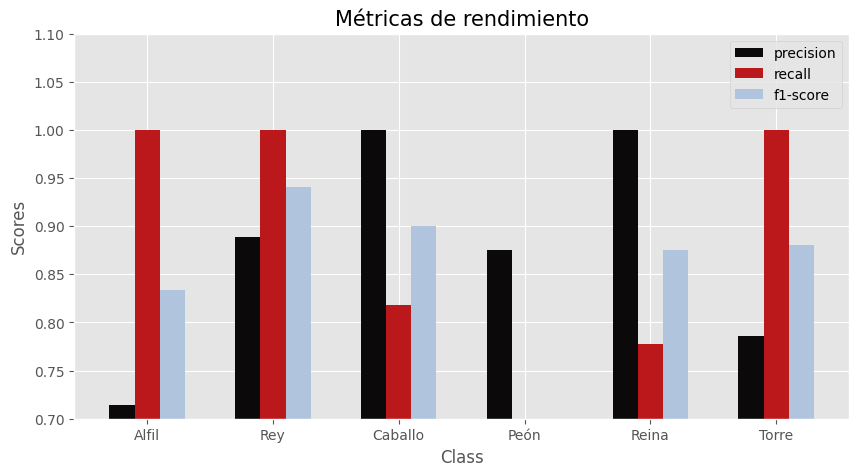

In [29]:
# Calcular el reporte de clasificación (precisión, recall y F1-score)
report = classification_report(test_true, test_pred, output_dict=True)

# Definir las métricas clave a visualizar
metrics = ["precision", "recall", "f1-score"]

# Inicializar lista para almacenar los puntajes por clase
class_scores = []

# Recorrer las 6 clases y extraer los valores de cada métrica
for i in range(6):
    class_scores.append([report[str(i)][metric] for metric in metrics])

# Crear una figura para el gráfico de barras
fig, ax = plt.subplots(figsize=(10, 5))

# Definir el ancho de cada barra
bar_width = 0.2

# Dibujar las barras comparativas para cada métrica
for i, scores in enumerate(class_scores):
    ax.bar(i - bar_width, scores[0], bar_width, color="#0b090a")  # Precisión
    ax.bar(i, scores[1], bar_width, color="#ba181b")  # Recall
    ax.bar(i + bar_width, scores[2], bar_width, color="#b0c4de")  # F1-score

# Configurar el gráfico
ax.set_xlabel("Class")  # Etiqueta del eje X
ax.set_ylabel("Scores")  # Etiqueta del eje Y
ax.set_ylim(0.7, 1.1)  # Fijar el rango del eje Y
ax.legend(metrics)  # Agregar leyenda
ax.set_xticks([0, 1, 2, 3, 4, 5])  # Posicionar etiquetas de las clases
ax.set_xticklabels(clases)  # Asignar nombres de clases al eje X
ax.set_title("Métricas de rendimiento", fontsize=15)  # Agregar título


## Matriz de Confusión: Análisis de errores en el Test Set

En esta celda, se calcula y visualiza la **matriz de confusión**, una herramienta clave para analizar los errores del modelo en la clasificación.

### Pasos realizados:
1️⃣ **Calcular la matriz de confusión (`tf.math.confusion_matrix`)**  
   - Compara **etiquetas verdaderas** (`test_true`) vs. **predicciones del modelo** (`test_pred`).  
   - Genera una matriz donde:  
     - **Filas** → Clases reales.  
     - **Columnas** → Clases predichas.  

2️⃣ **Visualizar la matriz de confusión con `seaborn.heatmap()`**  
   - Se usa `cmap='rocket_r'` para un color degradado intuitivo.  
   - Se anotan los valores dentro de la matriz (`annot=True`).  

3️⃣ **Configurar el gráfico**  
   - Etiquetas en los ejes con los nombres de las clases (`class_names`).  
   - Ajuste de alineación en las etiquetas (`va="center"`, `ha="center"`).  
   - Personalización de títulos y etiquetas para mayor claridad.  

### Objetivo:
La matriz de confusión permite identificar **clases donde el modelo comete más errores**, ayudando a mejorar su precisión en futuras optimizaciones.


Text(0.5, 1.0, 'Matriz de confusión')

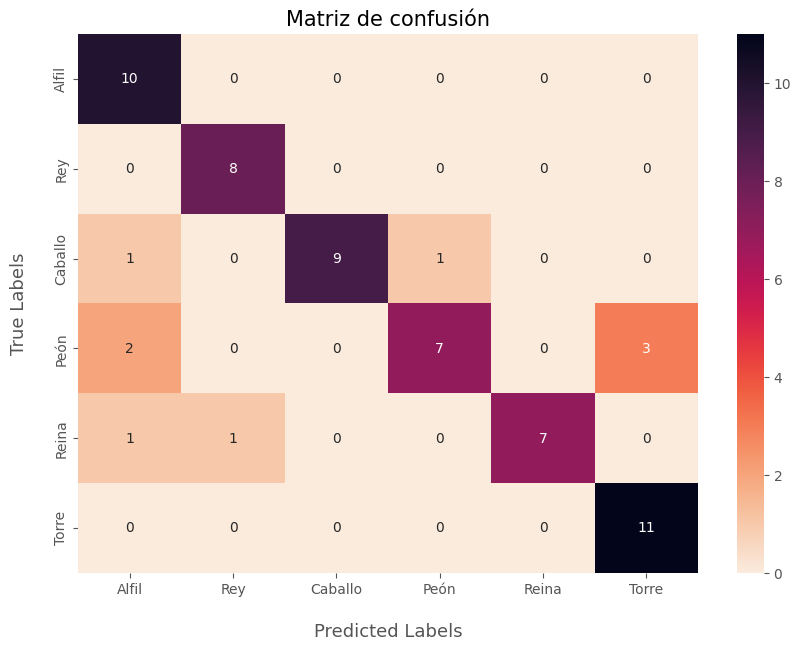

In [31]:
# Calcular la matriz de confusión comparando etiquetas reales y predichas
cm = tf.math.confusion_matrix(test_true, test_pred)

# Crear una figura para visualizar la matriz de confusión
fig, ax = plt.subplots(figsize=(10, 7))

# Dibujar la matriz de confusión como un heatmap con anotaciones
sns.heatmap(cm, annot=True, fmt='', ax=ax, cmap='rocket_r')

# Configurar etiquetas en los ejes
ax.set_yticklabels(clases, va="center")  # Etiquetas en el eje Y (clases reales)
ax.set_xticklabels(clases, ha="center")  # Etiquetas en el eje X (clases predichas)

# Agregar etiquetas a los ejes
ax.set_xlabel('\nPredicted Labels', fontsize=13)  # Etiqueta del eje X
ax.set_ylabel('True Labels\n', fontsize=13)  # Etiqueta del eje Y

# Agregar título al gráfico
plt.title("Matriz de confusión", fontsize=15)